In [2]:
import os
import torch
import torchvision
from torch import nn
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [4]:
transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.ToTensor(),
    ]
)

batch_size = 5

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

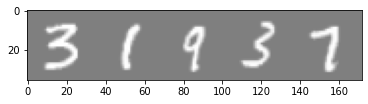

    3    1    9    3    7


In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(''.join('%5s' % int(labels[j]) for j in range(batch_size)))

In [7]:
images[0].shape

torch.Size([1, 32, 32])

In [8]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),

            nn.Flatten(),

            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(inplace=True),

            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.features(x)
        return x

In [9]:
leNet = LeNet5()
leNet.to(device)

LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU(inplace=True)
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(leNet.parameters(), lr=0.001, momentum=0.9)

In [11]:
minimum_updates = 1000
minibatches_proccesed = 0
best_model_loss = 1e20
best_model_minibatch_time = 0
isStop = False
eval_interval = 1000
PATH = './lenet.pth'

epoch = 0
while not isStop:
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        # https://stackoverflow.com/questions/59013109/runtimeerror-input-type-torch-floattensor-and-weight-type-torch-cuda-floatte/59013131
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()
        leNet.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = leNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        preds = torch.argmax(outputs.data, dim=1)

        running_loss += loss.item()
        running_accuracy += (labels == preds).float().mean()

        minibatches_proccesed += 1

        if minibatches_proccesed % eval_interval == (eval_interval - 1):
            if running_loss < best_model_loss and (running_accuracy / eval_interval) >= 0.7:
                best_model_loss = running_loss
                best_model_minibatch_time = minibatches_proccesed
                torch.save(leNet.state_dict(), PATH)

            if minibatches_proccesed > minimum_updates and minibatches_proccesed >= best_model_minibatch_time + minimum_updates:
                isStop = True

            print('[%d, %5d] loss: %.3f, accuracy: %.3f' % (epoch + 1, minibatches_proccesed + 1, running_loss / eval_interval, running_accuracy / eval_interval))
            running_loss = 0.0
            running_accuracy = 0.0
            
    epoch += 1

print('Finished Training')

[1,  1000] loss: 2.297, accuracy: 0.125
[1,  2000] loss: 2.052, accuracy: 0.294
[1,  3000] loss: 0.540, accuracy: 0.834
[1,  4000] loss: 0.269, accuracy: 0.914
[1,  5000] loss: 0.197, accuracy: 0.937
[1,  6000] loss: 0.169, accuracy: 0.946
[1,  7000] loss: 0.134, accuracy: 0.958
[1,  8000] loss: 0.130, accuracy: 0.962
[1,  9000] loss: 0.123, accuracy: 0.961
[1, 10000] loss: 0.100, accuracy: 0.969
[1, 11000] loss: 0.097, accuracy: 0.974
[1, 12000] loss: 0.119, accuracy: 0.964
Finished Training


# Validation

---


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [13]:
PATH = './mnist_net.pth'
leNet = LeNet5()
leNet.load_state_dict(torch.load(PATH))
leNet.to(device)

LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU(inplace=True)
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [14]:
outputs = leNet(images.cuda())

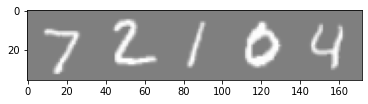

GroundTruth:      7     2     1     0     4
Predicted:      7     2     1     0     4


In [15]:
_, predicted = torch.max(outputs, 1)

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % int(labels[j]) for j in range(batch_size)))

print('Predicted: ', ' '.join('%5s' % int(predicted[j]) for j in range(batch_size)))

In [16]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = leNet(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


In [17]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in range(10)}
total_pred = {classname: 0 for classname in range(10)}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        outputs = leNet(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[int(label)] += 1
            total_pred[int(label)] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:d} is: {:.1f} %".format(classname, accuracy))

Accuracy for class 0 is: 99.1 %
Accuracy for class 1 is: 98.8 %
Accuracy for class 2 is: 99.2 %
Accuracy for class 3 is: 99.0 %
Accuracy for class 4 is: 94.2 %
Accuracy for class 5 is: 97.6 %
Accuracy for class 6 is: 99.5 %
Accuracy for class 7 is: 98.4 %
Accuracy for class 8 is: 98.2 %
Accuracy for class 9 is: 96.0 %
